In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_1dim100_omega_b_NL.npz')                #LHS  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['omega_b']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['omega_b'])
print('number of training samples:', len(train_params['omega_b'])) 
print(train_params['omega_b'])

number of training samples: 100
[0.01969697 0.02153535 0.01948485 0.02005051 0.02033333 0.01856566
 0.02478788 0.01828283 0.02139394 0.02337374 0.02068687 0.01976768
 0.01842424 0.02393939 0.02160606 0.02125253 0.01849495 0.02464646
 0.02379798 0.0199798  0.01814141 0.02224242 0.02188889 0.02351515
 0.01863636 0.0209697  0.018      0.02450505 0.02280808 0.02054545
 0.02372727 0.02111111 0.02012121 0.0240101  0.01913131 0.01835354
 0.02471717 0.01955556 0.01927273 0.02252525 0.01870707 0.02422222
 0.01962626 0.01983838 0.01934343 0.02492929 0.02181818 0.01990909
 0.02019192 0.02174747 0.02266667 0.02457576 0.02386869 0.0230202
 0.0210404  0.02132323 0.02273737 0.02415152 0.01891919 0.02344444
 0.02118182 0.01821212 0.02309091 0.02075758 0.0220303  0.02485859
 0.01920202 0.02408081 0.02287879 0.01906061 0.01884848 0.02436364
 0.02231313 0.01941414 0.02146465 0.02089899 0.02167677 0.02429293
 0.02210101 0.02294949 0.01807071 0.02040404 0.02061616 0.02047475
 0.02358586 0.02443434 0.022171

In [6]:
cosmo_params = np.zeros((len(train_params['omega_b']), 1))
print(cosmo_params[4])

cosmo_params[:, 0] = train_params['omega_b']

## Training input params:
omega_b = cosmo_params[:, 0]

[0.]


In [7]:
with open('pk_data_1dim100_omega_b_NL1.pkl', 'rb') as f, open('pk_data_1dim100_omega_b_NL2.pkl', 'rb') as g:
    pk_matrix = pickle.load(f)
    pk_nonlin_matrix = pickle.load(g)

pk_matrix = np.asarray(pk_matrix).astype('float32')
pk_matrix.dtype

In [10]:
omega_b.dtype

dtype('float64')

In [11]:
# Training input params and output param:

train_omega_b = omega_b                          
train_pk = pk_matrix                    
train_pk_nonlin = pk_nonlin_matrix 
print("train_pk shape:", np.shape(train_pk))
print("train_pk_nonlin shape:", np.shape(train_pk_nonlin))
print(len(train_pk[4]))

train_pk shape: (100, 500)
train_pk_nonlin shape: (100, 500)
500


In [12]:
input_params = np.vstack([train_omega_b])                                        # 1x5000

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['Omega_b']

output_data = pd.DataFrame(train_pk)
output_data_nonlin = pd.DataFrame(train_pk_nonlin)  
print(input_data)                                                         #5000x1
print(output_data)

(100, 1)
(100, 500)
     Omega_b
0   0.019697
1   0.021535
2   0.019485
3   0.020051
4   0.020333
..       ...
95  0.020263
96  0.023303
97  0.022596
98  0.023232
99  0.018990

[100 rows x 1 columns]
           0           1           2           3           4           5    \
0   420.735226  430.555464  440.604654  450.888114  461.411285  472.179734   
1   424.941255  434.859777  445.009558  455.395966  466.024498  476.900774   
2   420.245313  430.054092  440.091559  450.363026  460.873929  471.629831   
3   421.549997  431.389282  441.457953  451.761341  462.304905  473.094228   
4   422.199961  432.054420  442.138634  452.457941  463.017804  473.823814   
..         ...         ...         ...         ...         ...         ...   
95  422.037587  431.888265  441.968609  452.283954  462.839756  473.641601   
96  428.892816  438.903682  449.147965  459.631085  470.358588  481.336148   
97  427.318793  437.292873  447.499505  457.944093  468.632170  479.569396   
98  428.735905  438.

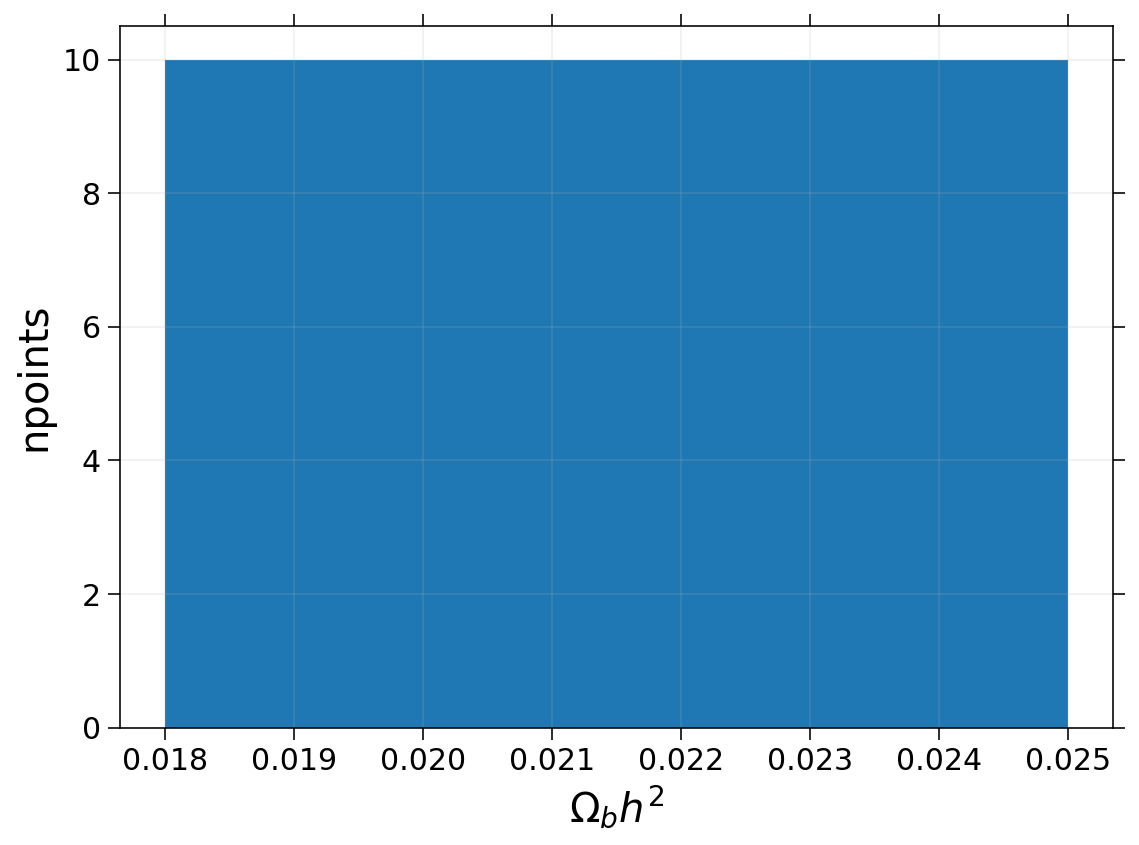

In [14]:
plt.figure(figsize = (8,6))
plt.hist(input_data['Omega_b'])
plt.xlabel(r'$\Omega_{b}h^{2}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()

In [15]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

# Storing the fit object for later reference
scaled_input = train_input_data.fit(input_data.values)              # Compute the mean and std to be used for later scaling

scaled_output = test_output_data.fit(output_data.values)
scaled_output_nonlin = test_output_data.fit(output_data_nonlin.values)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data.values)                              # Perform standardisation by centring and scaling    
y = scaled_output.transform(output_data.values)     
y_nonlin = scaled_output_nonlin.transform(output_data_nonlin.values)
#print(X)

-1.7148160424389371 196.85246014814447


(array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([-1.71481604e+00, -1.37185283e+00, -1.02888963e+00, -6.85926417e-01,
        -3.42963208e-01,  8.88178420e-16,  3.42963208e-01,  6.85926417e-01,
         1.02888963e+00,  1.37185283e+00,  1.71481604e+00]),
 <BarContainer object of 10 artists>)

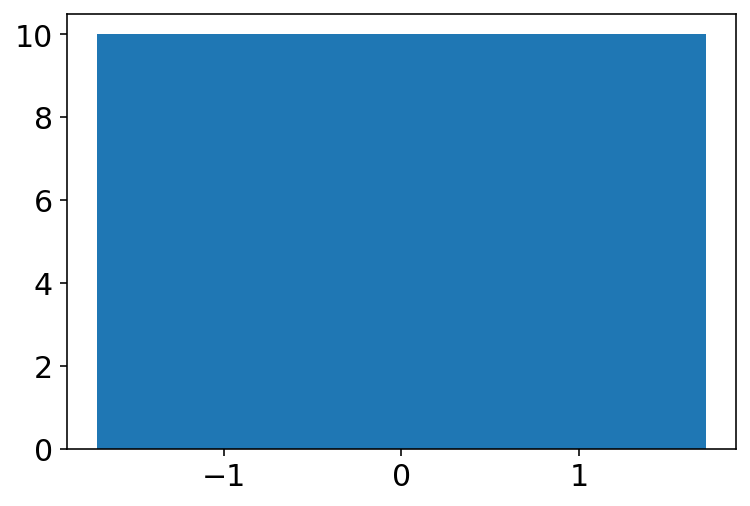

In [16]:
print(X.min(), y.max())
plt.hist(X)

In [17]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 4000x1
print(X_train.shape[1])     # 1


X_train_nonlin, X_test_nonlin, y_train_nonlin, y_test_nonlin = train_test_split(X, y_nonlin, test_size=0.2, random_state=42)
print(np.shape(X_train_nonlin))
print(X_train.shape[1])    

(80, 1)
1
(80, 1)
1


In [18]:
#print(X_train)

In [19]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test samples, pts:",np.shape(X_test))

print("y_test_nonlin samples, pts:", np.shape(y_test_nonlin))
print("y_train_nonlin samples, pts:", np.shape(y_train_nonlin))
print("X_train_nonlin samples, pts:", np.shape(X_train_nonlin))
print("X_test_nonlin samples, pts:",np.shape(X_test_nonlin))
#print("X_train:", X_train)
#print("X_test:", X_test)

y_test samples, pts: (20, 500)
y_train samples, pts: (80, 500)
X_train samples, pts: (80, 1)
X_test samples, pts: (20, 1)
y_test_nonlin samples, pts: (20, 500)
y_train_nonlin samples, pts: (80, 500)
X_train_nonlin samples, pts: (80, 1)
X_test_nonlin samples, pts: (20, 1)


In [20]:
%%time
#Building the NN:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 2, epochs = 500, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model.summary()

Epoch 1/500
32/32 [==============================] - 1s 6ms/step - loss: 1652.4874 - accuracy: 0.2188 - val_loss: 1644.0732 - val_accuracy: 0.5000
Epoch 2/500
32/32 [==============================] - 0s 3ms/step - loss: 1651.0389 - accuracy: 0.5469 - val_loss: 1641.7637 - val_accuracy: 0.5000
Epoch 3/500
32/32 [==============================] - 0s 3ms/step - loss: 1645.5853 - accuracy: 0.7812 - val_loss: 1632.3506 - val_accuracy: 1.0000
Epoch 4/500
32/32 [==============================] - 0s 3ms/step - loss: 1625.0791 - accuracy: 1.0000 - val_loss: 1600.7190 - val_accuracy: 1.0000
Epoch 5/500
32/32 [==============================] - 0s 3ms/step - loss: 1565.2367 - accuracy: 1.0000 - val_loss: 1515.0076 - val_accuracy: 1.0000
Epoch 6/500
32/32 [==============================] - 0s 3ms/step - loss: 1428.7126 - accuracy: 1.0000 - val_loss: 1333.2493 - val_accuracy: 1.0000
Epoch 7/500
32/32 [==============================] - 0s 3ms/step - loss: 1179.4615 - accuracy: 1.0000 - val_loss: 1038

32/32 [==============================] - 0s 3ms/step - loss: 3.3209 - accuracy: 1.0000 - val_loss: 2.6205 - val_accuracy: 1.0000
Epoch 59/500
32/32 [==============================] - 0s 3ms/step - loss: 3.2181 - accuracy: 1.0000 - val_loss: 2.6702 - val_accuracy: 1.0000
Epoch 60/500
32/32 [==============================] - 0s 3ms/step - loss: 3.2416 - accuracy: 1.0000 - val_loss: 2.4446 - val_accuracy: 1.0000
Epoch 61/500
32/32 [==============================] - 0s 3ms/step - loss: 3.2221 - accuracy: 1.0000 - val_loss: 2.7380 - val_accuracy: 1.0000
Epoch 62/500
32/32 [==============================] - 0s 2ms/step - loss: 3.0832 - accuracy: 1.0000 - val_loss: 2.5455 - val_accuracy: 1.0000
Epoch 63/500
32/32 [==============================] - 0s 3ms/step - loss: 2.9972 - accuracy: 1.0000 - val_loss: 2.3505 - val_accuracy: 1.0000
Epoch 64/500
32/32 [==============================] - 0s 2ms/step - loss: 3.0890 - accuracy: 1.0000 - val_loss: 2.2615 - val_accuracy: 1.0000
Epoch 65/500
32/32 

Epoch 116/500
32/32 [==============================] - 0s 3ms/step - loss: 1.9721 - accuracy: 1.0000 - val_loss: 1.4253 - val_accuracy: 1.0000
Epoch 117/500
32/32 [==============================] - 0s 3ms/step - loss: 1.9247 - accuracy: 1.0000 - val_loss: 1.4408 - val_accuracy: 1.0000
Epoch 118/500
32/32 [==============================] - 0s 2ms/step - loss: 1.9356 - accuracy: 1.0000 - val_loss: 1.4985 - val_accuracy: 1.0000
Epoch 119/500
32/32 [==============================] - 0s 3ms/step - loss: 1.8592 - accuracy: 1.0000 - val_loss: 1.4036 - val_accuracy: 1.0000
Epoch 120/500
32/32 [==============================] - 0s 3ms/step - loss: 1.9070 - accuracy: 1.0000 - val_loss: 1.3787 - val_accuracy: 1.0000
Epoch 121/500
32/32 [==============================] - 0s 3ms/step - loss: 1.8404 - accuracy: 1.0000 - val_loss: 1.4819 - val_accuracy: 1.0000
Epoch 122/500
32/32 [==============================] - 0s 3ms/step - loss: 1.8460 - accuracy: 1.0000 - val_loss: 1.3734 - val_accuracy: 1.0000

32/32 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 1.0000 - val_loss: 0.4676 - val_accuracy: 1.0000
Epoch 174/500
32/32 [==============================] - 0s 3ms/step - loss: 0.5823 - accuracy: 1.0000 - val_loss: 0.4502 - val_accuracy: 1.0000
Epoch 175/500
32/32 [==============================] - 0s 3ms/step - loss: 0.5577 - accuracy: 1.0000 - val_loss: 0.4301 - val_accuracy: 1.0000
Epoch 176/500
32/32 [==============================] - 0s 3ms/step - loss: 0.5322 - accuracy: 1.0000 - val_loss: 0.4022 - val_accuracy: 1.0000
Epoch 177/500
32/32 [==============================] - 0s 3ms/step - loss: 0.5094 - accuracy: 1.0000 - val_loss: 0.3867 - val_accuracy: 1.0000
Epoch 178/500
32/32 [==============================] - 0s 3ms/step - loss: 0.4840 - accuracy: 1.0000 - val_loss: 0.3708 - val_accuracy: 1.0000
Epoch 179/500
32/32 [==============================] - 0s 3ms/step - loss: 0.4715 - accuracy: 1.0000 - val_loss: 0.3620 - val_accuracy: 1.0000
Epoch 180/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0357 - accuracy: 1.0000 - val_loss: 0.0322 - val_accuracy: 1.0000
Epoch 231/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0347 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 1.0000
Epoch 232/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 1.0000
Epoch 233/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0337 - accuracy: 1.0000 - val_loss: 0.0360 - val_accuracy: 1.0000
Epoch 234/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0395 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 1.0000
Epoch 235/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 1.0000
Epoch 236/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 1.0000
Epoch 237/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 288/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 1.0000
Epoch 289/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 1.0000
Epoch 290/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0302 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 1.0000
Epoch 291/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 292/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 0.0328 - val_accuracy: 1.0000
Epoch 293/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 294/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 345/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0340 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 346/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0315 - accuracy: 1.0000 - val_loss: 0.0332 - val_accuracy: 1.0000
Epoch 347/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.0303 - val_accuracy: 1.0000
Epoch 348/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 1.0000
Epoch 349/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0318 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 350/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 351/500

32/32 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 1.0000
Epoch 402/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 403/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 1.0000
Epoch 404/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 405/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0577 - accuracy: 1.0000 - val_loss: 0.0748 - val_accuracy: 1.0000
Epoch 406/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0734 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 1.0000
Epoch 407/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 1.0000
Epoch 408/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 1.0000
Epoch 459/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 460/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 1.0000
Epoch 461/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 1.0000
Epoch 462/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 463/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 464/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 1.0000
Epoch 465/500

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

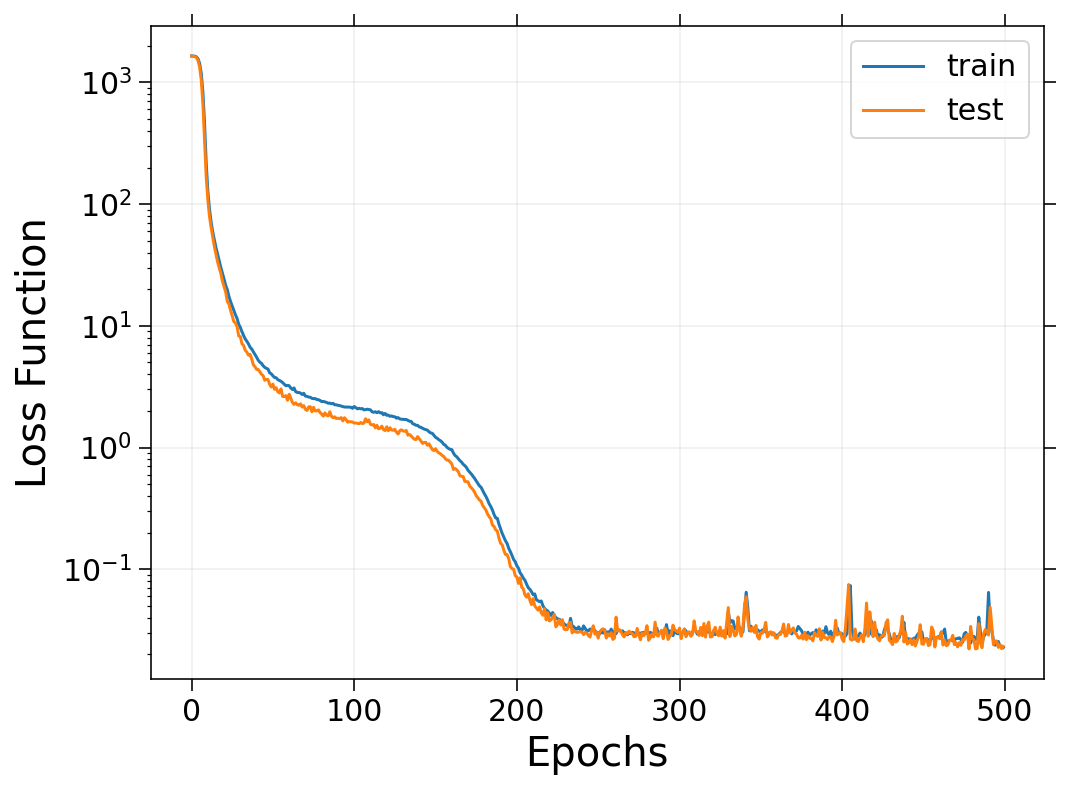

In [21]:
#Linear case:
plt.figure(figsize = (8,6))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_H0.jpg')
plt.tight_layout

In [22]:
%%time
#Building the NN for NONLINEAR:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model_nonlin = Sequential()
# Defining the input layer of the model
tf_model_nonlin.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model_nonlin.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model_nonlin.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model_nonlin.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model_nonlin.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model_nonlin.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
#opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model_nonlin.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_nonlin = tf_model_nonlin.fit(X_train_nonlin, y_train_nonlin, batch_size = 2, epochs = 500, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test_nonlin - tf_model_nonlin.predict(X_test_nonlin))/y_test_nonlin))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model_nonlin.summary()

Epoch 1/500
32/32 [==============================] - 0s 6ms/step - loss: 0.9174 - accuracy: 0.0000e+00 - val_loss: 0.4147 - val_accuracy: 0.0000e+00
Epoch 2/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1718 - accuracy: 0.0000e+00 - val_loss: 0.0356 - val_accuracy: 0.0000e+00
Epoch 3/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0275 - accuracy: 0.0938 - val_loss: 0.0222 - val_accuracy: 0.0625
Epoch 4/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.0312 - val_loss: 0.0192 - val_accuracy: 0.0000e+00
Epoch 5/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0175 - accuracy: 0.0469 - val_loss: 0.0174 - val_accuracy: 0.0000e+00
Epoch 6/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0163 - accuracy: 0.0469 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 7/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0158 - accuracy: 0.0625 - val_loss: 0.0164 - val_ac

Epoch 58/500
32/32 [==============================] - 0s 2ms/step - loss: 7.0224e-04 - accuracy: 0.5938 - val_loss: 6.4853e-04 - val_accuracy: 0.4375
Epoch 59/500
32/32 [==============================] - 0s 2ms/step - loss: 6.4346e-04 - accuracy: 0.6250 - val_loss: 6.7618e-04 - val_accuracy: 0.5000
Epoch 60/500
32/32 [==============================] - 0s 2ms/step - loss: 6.3156e-04 - accuracy: 0.6250 - val_loss: 6.3994e-04 - val_accuracy: 0.5000
Epoch 61/500
32/32 [==============================] - 0s 2ms/step - loss: 6.3235e-04 - accuracy: 0.6562 - val_loss: 6.9746e-04 - val_accuracy: 0.5000
Epoch 62/500
32/32 [==============================] - 0s 2ms/step - loss: 6.3208e-04 - accuracy: 0.6406 - val_loss: 6.6027e-04 - val_accuracy: 0.6250
Epoch 63/500
32/32 [==============================] - 0s 2ms/step - loss: 5.9283e-04 - accuracy: 0.6562 - val_loss: 6.4868e-04 - val_accuracy: 0.6250
Epoch 64/500
32/32 [==============================] - 0s 3ms/step - loss: 5.5936e-04 - accuracy: 0.6

32/32 [==============================] - 0s 3ms/step - loss: 2.8640e-04 - accuracy: 0.7969 - val_loss: 3.4664e-04 - val_accuracy: 0.7500
Epoch 113/500
32/32 [==============================] - 0s 3ms/step - loss: 3.1897e-04 - accuracy: 0.7812 - val_loss: 2.6934e-04 - val_accuracy: 0.7500
Epoch 114/500
32/32 [==============================] - 0s 3ms/step - loss: 2.8339e-04 - accuracy: 0.7969 - val_loss: 2.7849e-04 - val_accuracy: 0.7500
Epoch 115/500
32/32 [==============================] - 0s 3ms/step - loss: 2.9792e-04 - accuracy: 0.7969 - val_loss: 2.7550e-04 - val_accuracy: 0.7500
Epoch 116/500
32/32 [==============================] - 0s 3ms/step - loss: 2.8927e-04 - accuracy: 0.7969 - val_loss: 3.1115e-04 - val_accuracy: 0.7500
Epoch 117/500
32/32 [==============================] - 0s 3ms/step - loss: 2.6835e-04 - accuracy: 0.7969 - val_loss: 2.6701e-04 - val_accuracy: 0.7500
Epoch 118/500
32/32 [==============================] - 0s 3ms/step - loss: 2.7627e-04 - accuracy: 0.7812 - v

32/32 [==============================] - 0s 3ms/step - loss: 1.8086e-04 - accuracy: 0.8281 - val_loss: 1.9500e-04 - val_accuracy: 0.8125
Epoch 167/500
32/32 [==============================] - 0s 4ms/step - loss: 1.8376e-04 - accuracy: 0.8750 - val_loss: 2.4993e-04 - val_accuracy: 0.7500
Epoch 168/500
32/32 [==============================] - 0s 3ms/step - loss: 1.8980e-04 - accuracy: 0.8438 - val_loss: 1.8638e-04 - val_accuracy: 0.7500
Epoch 169/500
32/32 [==============================] - 0s 3ms/step - loss: 1.6450e-04 - accuracy: 0.8438 - val_loss: 1.6210e-04 - val_accuracy: 0.7500
Epoch 170/500
32/32 [==============================] - 0s 3ms/step - loss: 1.5714e-04 - accuracy: 0.8438 - val_loss: 1.8121e-04 - val_accuracy: 0.8125
Epoch 171/500
32/32 [==============================] - 0s 3ms/step - loss: 1.5680e-04 - accuracy: 0.8438 - val_loss: 1.6662e-04 - val_accuracy: 0.7500
Epoch 172/500
32/32 [==============================] - 0s 3ms/step - loss: 1.6112e-04 - accuracy: 0.8438 - v

32/32 [==============================] - 0s 3ms/step - loss: 1.1895e-04 - accuracy: 0.9062 - val_loss: 1.5914e-04 - val_accuracy: 0.8125
Epoch 221/500
32/32 [==============================] - 0s 3ms/step - loss: 1.2034e-04 - accuracy: 0.9062 - val_loss: 1.4455e-04 - val_accuracy: 0.7500
Epoch 222/500
32/32 [==============================] - 0s 3ms/step - loss: 1.1881e-04 - accuracy: 0.9062 - val_loss: 1.3813e-04 - val_accuracy: 0.8125
Epoch 223/500
32/32 [==============================] - 0s 3ms/step - loss: 1.0969e-04 - accuracy: 0.9219 - val_loss: 1.4283e-04 - val_accuracy: 0.8750
Epoch 224/500
32/32 [==============================] - 0s 3ms/step - loss: 1.4439e-04 - accuracy: 0.9219 - val_loss: 2.1379e-04 - val_accuracy: 0.8125
Epoch 225/500
32/32 [==============================] - 0s 3ms/step - loss: 1.7085e-04 - accuracy: 0.8750 - val_loss: 2.4816e-04 - val_accuracy: 0.7500
Epoch 226/500
32/32 [==============================] - 0s 3ms/step - loss: 1.5797e-04 - accuracy: 0.9062 - v

32/32 [==============================] - 0s 3ms/step - loss: 1.1183e-04 - accuracy: 0.9375 - val_loss: 1.3308e-04 - val_accuracy: 0.7500
Epoch 275/500
32/32 [==============================] - 0s 3ms/step - loss: 1.9391e-04 - accuracy: 0.9062 - val_loss: 3.1939e-04 - val_accuracy: 0.6875
Epoch 276/500
32/32 [==============================] - 0s 2ms/step - loss: 2.3919e-04 - accuracy: 0.9062 - val_loss: 1.4717e-04 - val_accuracy: 0.7500
Epoch 277/500
32/32 [==============================] - 0s 2ms/step - loss: 2.0137e-04 - accuracy: 0.8906 - val_loss: 2.9331e-04 - val_accuracy: 0.7500
Epoch 278/500
32/32 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.8594 - val_loss: 9.3135e-04 - val_accuracy: 0.7500
Epoch 279/500
32/32 [==============================] - 0s 3ms/step - loss: 6.9589e-04 - accuracy: 0.8750 - val_loss: 4.3258e-04 - val_accuracy: 0.7500
Epoch 280/500
32/32 [==============================] - 0s 3ms/step - loss: 2.5785e-04 - accuracy: 0.8750 - val_l

32/32 [==============================] - 0s 3ms/step - loss: 7.6317e-05 - accuracy: 0.9062 - val_loss: 1.2829e-04 - val_accuracy: 0.7500
Epoch 329/500
32/32 [==============================] - 0s 3ms/step - loss: 9.2542e-05 - accuracy: 0.8906 - val_loss: 1.6049e-04 - val_accuracy: 0.7500
Epoch 330/500
32/32 [==============================] - 0s 4ms/step - loss: 1.0359e-04 - accuracy: 0.9219 - val_loss: 1.4360e-04 - val_accuracy: 0.8125
Epoch 331/500
32/32 [==============================] - 0s 3ms/step - loss: 9.5946e-05 - accuracy: 0.8750 - val_loss: 1.2918e-04 - val_accuracy: 0.8125
Epoch 332/500
32/32 [==============================] - 0s 3ms/step - loss: 7.9565e-05 - accuracy: 0.8594 - val_loss: 1.2109e-04 - val_accuracy: 0.7500
Epoch 333/500
32/32 [==============================] - 0s 3ms/step - loss: 7.9475e-05 - accuracy: 0.8906 - val_loss: 1.2448e-04 - val_accuracy: 0.7500
Epoch 334/500
32/32 [==============================] - 0s 3ms/step - loss: 8.5084e-05 - accuracy: 0.8906 - v

32/32 [==============================] - 0s 3ms/step - loss: 1.0453e-04 - accuracy: 0.8906 - val_loss: 1.9483e-04 - val_accuracy: 0.7500
Epoch 383/500
32/32 [==============================] - 0s 3ms/step - loss: 1.6972e-04 - accuracy: 0.9062 - val_loss: 1.4565e-04 - val_accuracy: 0.7500
Epoch 384/500
32/32 [==============================] - 0s 3ms/step - loss: 1.3869e-04 - accuracy: 0.9062 - val_loss: 1.8096e-04 - val_accuracy: 0.7500
Epoch 385/500
32/32 [==============================] - 0s 3ms/step - loss: 9.3094e-05 - accuracy: 0.8906 - val_loss: 1.2519e-04 - val_accuracy: 0.7500
Epoch 386/500
32/32 [==============================] - 0s 3ms/step - loss: 7.5540e-05 - accuracy: 0.8906 - val_loss: 1.2551e-04 - val_accuracy: 0.7500
Epoch 387/500
32/32 [==============================] - 0s 3ms/step - loss: 6.9752e-05 - accuracy: 0.8906 - val_loss: 1.2147e-04 - val_accuracy: 0.7500
Epoch 388/500
32/32 [==============================] - 0s 3ms/step - loss: 7.9788e-05 - accuracy: 0.8906 - v

32/32 [==============================] - 0s 3ms/step - loss: 1.3784e-04 - accuracy: 0.8594 - val_loss: 1.5163e-04 - val_accuracy: 0.7500
Epoch 437/500
32/32 [==============================] - 0s 3ms/step - loss: 8.4768e-05 - accuracy: 0.8438 - val_loss: 1.2034e-04 - val_accuracy: 0.8125
Epoch 438/500
32/32 [==============================] - 0s 3ms/step - loss: 6.8229e-05 - accuracy: 0.8750 - val_loss: 1.1765e-04 - val_accuracy: 0.7500
Epoch 439/500
32/32 [==============================] - 0s 3ms/step - loss: 6.8072e-05 - accuracy: 0.8750 - val_loss: 1.1733e-04 - val_accuracy: 0.7500
Epoch 440/500
32/32 [==============================] - 0s 3ms/step - loss: 6.8385e-05 - accuracy: 0.9219 - val_loss: 1.2594e-04 - val_accuracy: 0.7500
Epoch 441/500
32/32 [==============================] - 0s 3ms/step - loss: 6.9185e-05 - accuracy: 0.8594 - val_loss: 1.1874e-04 - val_accuracy: 0.7500
Epoch 442/500
32/32 [==============================] - 0s 3ms/step - loss: 6.9721e-05 - accuracy: 0.8750 - v

32/32 [==============================] - 0s 2ms/step - loss: 7.4668e-05 - accuracy: 0.9062 - val_loss: 1.2402e-04 - val_accuracy: 0.7500
Epoch 491/500
32/32 [==============================] - 0s 2ms/step - loss: 7.5588e-05 - accuracy: 0.9062 - val_loss: 1.2690e-04 - val_accuracy: 0.7500
Epoch 492/500
32/32 [==============================] - 0s 2ms/step - loss: 6.8099e-05 - accuracy: 0.9062 - val_loss: 1.2121e-04 - val_accuracy: 0.7500
Epoch 493/500
32/32 [==============================] - 0s 2ms/step - loss: 7.2022e-05 - accuracy: 0.9062 - val_loss: 1.2529e-04 - val_accuracy: 0.7500
Epoch 494/500
32/32 [==============================] - 0s 3ms/step - loss: 7.8594e-05 - accuracy: 0.9219 - val_loss: 1.1783e-04 - val_accuracy: 0.7500
Epoch 495/500
32/32 [==============================] - 0s 3ms/step - loss: 1.2422e-04 - accuracy: 0.8750 - val_loss: 1.7332e-04 - val_accuracy: 0.7500
Epoch 496/500
32/32 [==============================] - 0s 3ms/step - loss: 2.1312e-04 - accuracy: 0.9062 - v

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

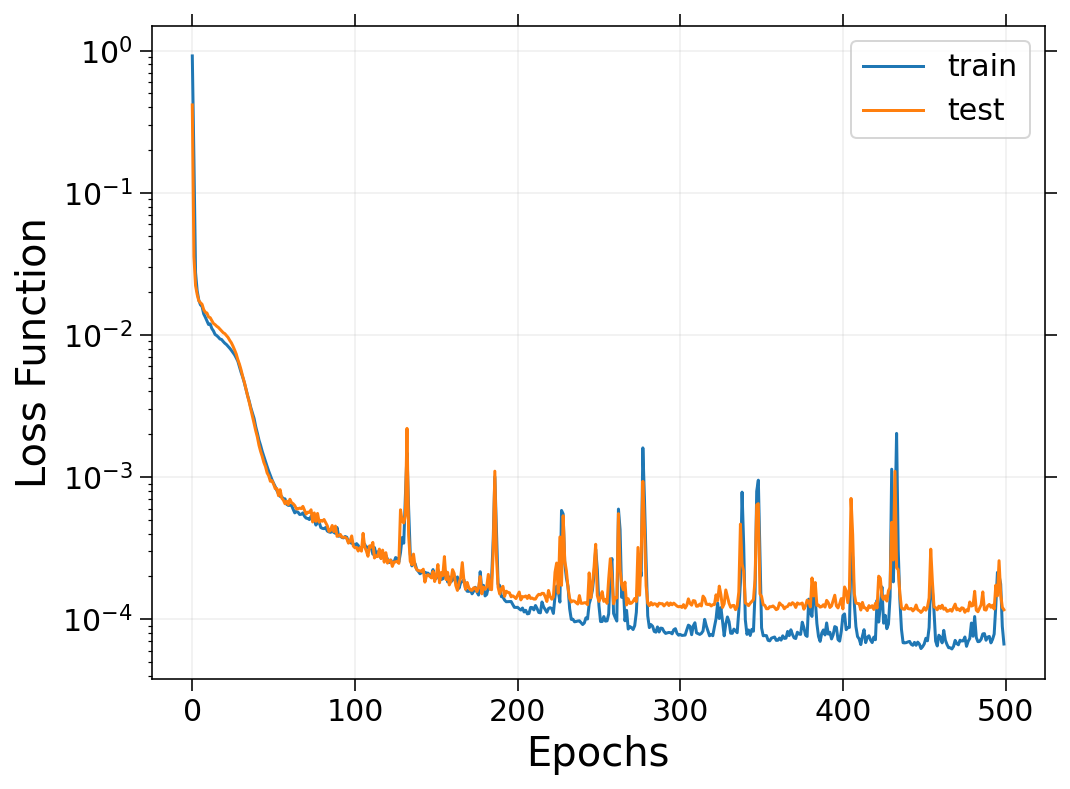

In [23]:
plt.figure(figsize = (8,6))
plt.plot(hist_nonlin.history["loss"], label="train")
plt.plot(hist_nonlin.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_H0.jpg')
plt.tight_layout

Omega_b: 0.0180 - 0.0250 0.02


parameter:  ['0.02']
user_list: [0.02]
cosmo_arr [[0.02]]
cosmo_arr[0] [0.02]
input_scaled [[-0.73492116]]
Omega_b: 0.02


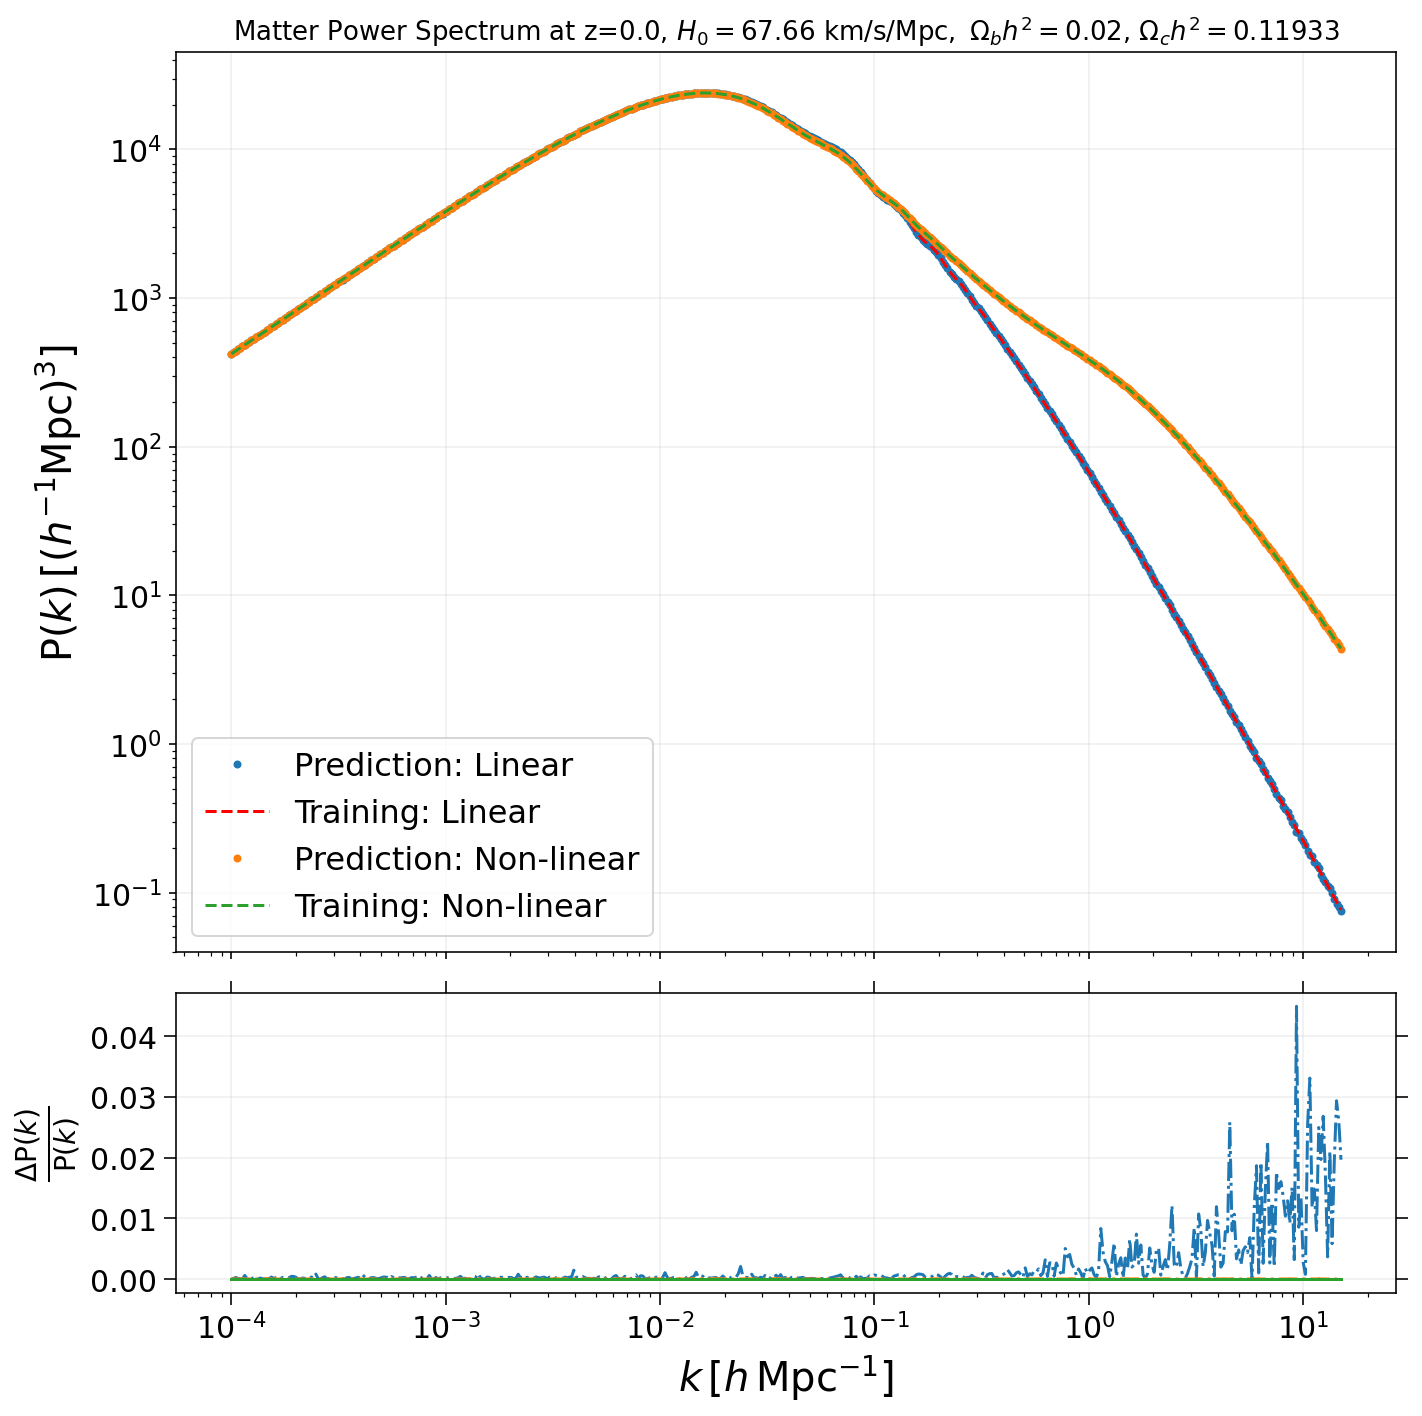

In [24]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('Omega_b: 0.0180 - 0.0250 ')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameter: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    #cosmo_arr_nonlin = np.reshape(np.array(user_list),(1, X_train_nonlin.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data.values)
    input_scaled = scaled.transform(cosmo_arr)
    #input_scaled_nonlin = scaled.transform(cosmo_arr_nonlin)
    print('input_scaled', input_scaled)
    
    pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
    pred_pk_nonlin = scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled]))
    #Return to log scale for pred:
    #pred_pk = np.exp(pred_rescaled_pk)
    
    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.66, ombh2=cosmo_arr[0][0], omch2=0.11933)
    pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur

    # Non-Linear spectra (Halofit)
    pars.NonLinear = model.NonLinear_both
    results.calc_power_spectra(pars)
    camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
    camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur

    print('Omega_b:' , cosmo_arr[0][0])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (10,10), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0.")                                                          # prediction                            
    ax[0].loglog(camb_kh, camb_pk[0], 'r', linestyle='dashed')                                          # CAMB
    ax[0].loglog(camb_kh, pred_pk_nonlin[0], "C1.")
    ax[0].loglog(camb_kh, camb_pk_nonlin[0], 'C2', linestyle='dashed') 
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = 67.66\ \mathregular{km/s/Mpc},$ ' + '$\Omega_{b}h^{2} = %0.7s$, '%cosmo_arr[0][0] + '$\Omega_{c}h^{2} = 0.11933$', fontsize = 13)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction: Linear', 'Training: Linear', 'Prediction: Non-linear', 'Training: Non-linear'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].plot(camb_kh, np.abs((pred_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C1', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C2')
    ax[1].set_yscale('linear')
    #ax[1].set_ylim(0, 0.05)
    fig.tight_layout()
    #plt.savefig('NN_MPS_H0.jpg')
    plt.show()
    

Generate = calc_cosmo()



parameter:  0.018
user_list: 0.018
cosmo_arr [[0.018]]
cosmo_arr[0] [0.018]
input_scaled [[-1.71481604]]
Omega_b: 0.018


parameter:  0.019
user_list: 0.019
cosmo_arr [[0.019]]
cosmo_arr[0] [0.019]
input_scaled [[-1.2248686]]
Omega_b: 0.019


parameter:  0.02
user_list: 0.02
cosmo_arr [[0.02]]
cosmo_arr[0] [0.02]
input_scaled [[-0.73492116]]
Omega_b: 0.02


parameter:  0.021
user_list: 0.021
cosmo_arr [[0.021]]
cosmo_arr[0] [0.021]
input_scaled [[-0.24497372]]
Omega_b: 0.021


parameter:  0.022
user_list: 0.022
cosmo_arr [[0.022]]
cosmo_arr[0] [0.022]
input_scaled [[0.24497372]]
Omega_b: 0.022


parameter:  0.023
user_list: 0.023
cosmo_arr [[0.023]]
cosmo_arr[0] [0.023]
input_scaled [[0.73492116]]
Omega_b: 0.023


parameter:  0.024
user_list: 0.024
cosmo_arr [[0.024]]
cosmo_arr[0] [0.024]
input_scaled [[1.2248686]]
Omega_b: 0.024


parameter:  0.025
user_list: 0.025
cosmo_arr [[0.025]]
cosmo_arr[0] [0.025]
input_scaled [[1.71481604]]
Omega_b: 0.025


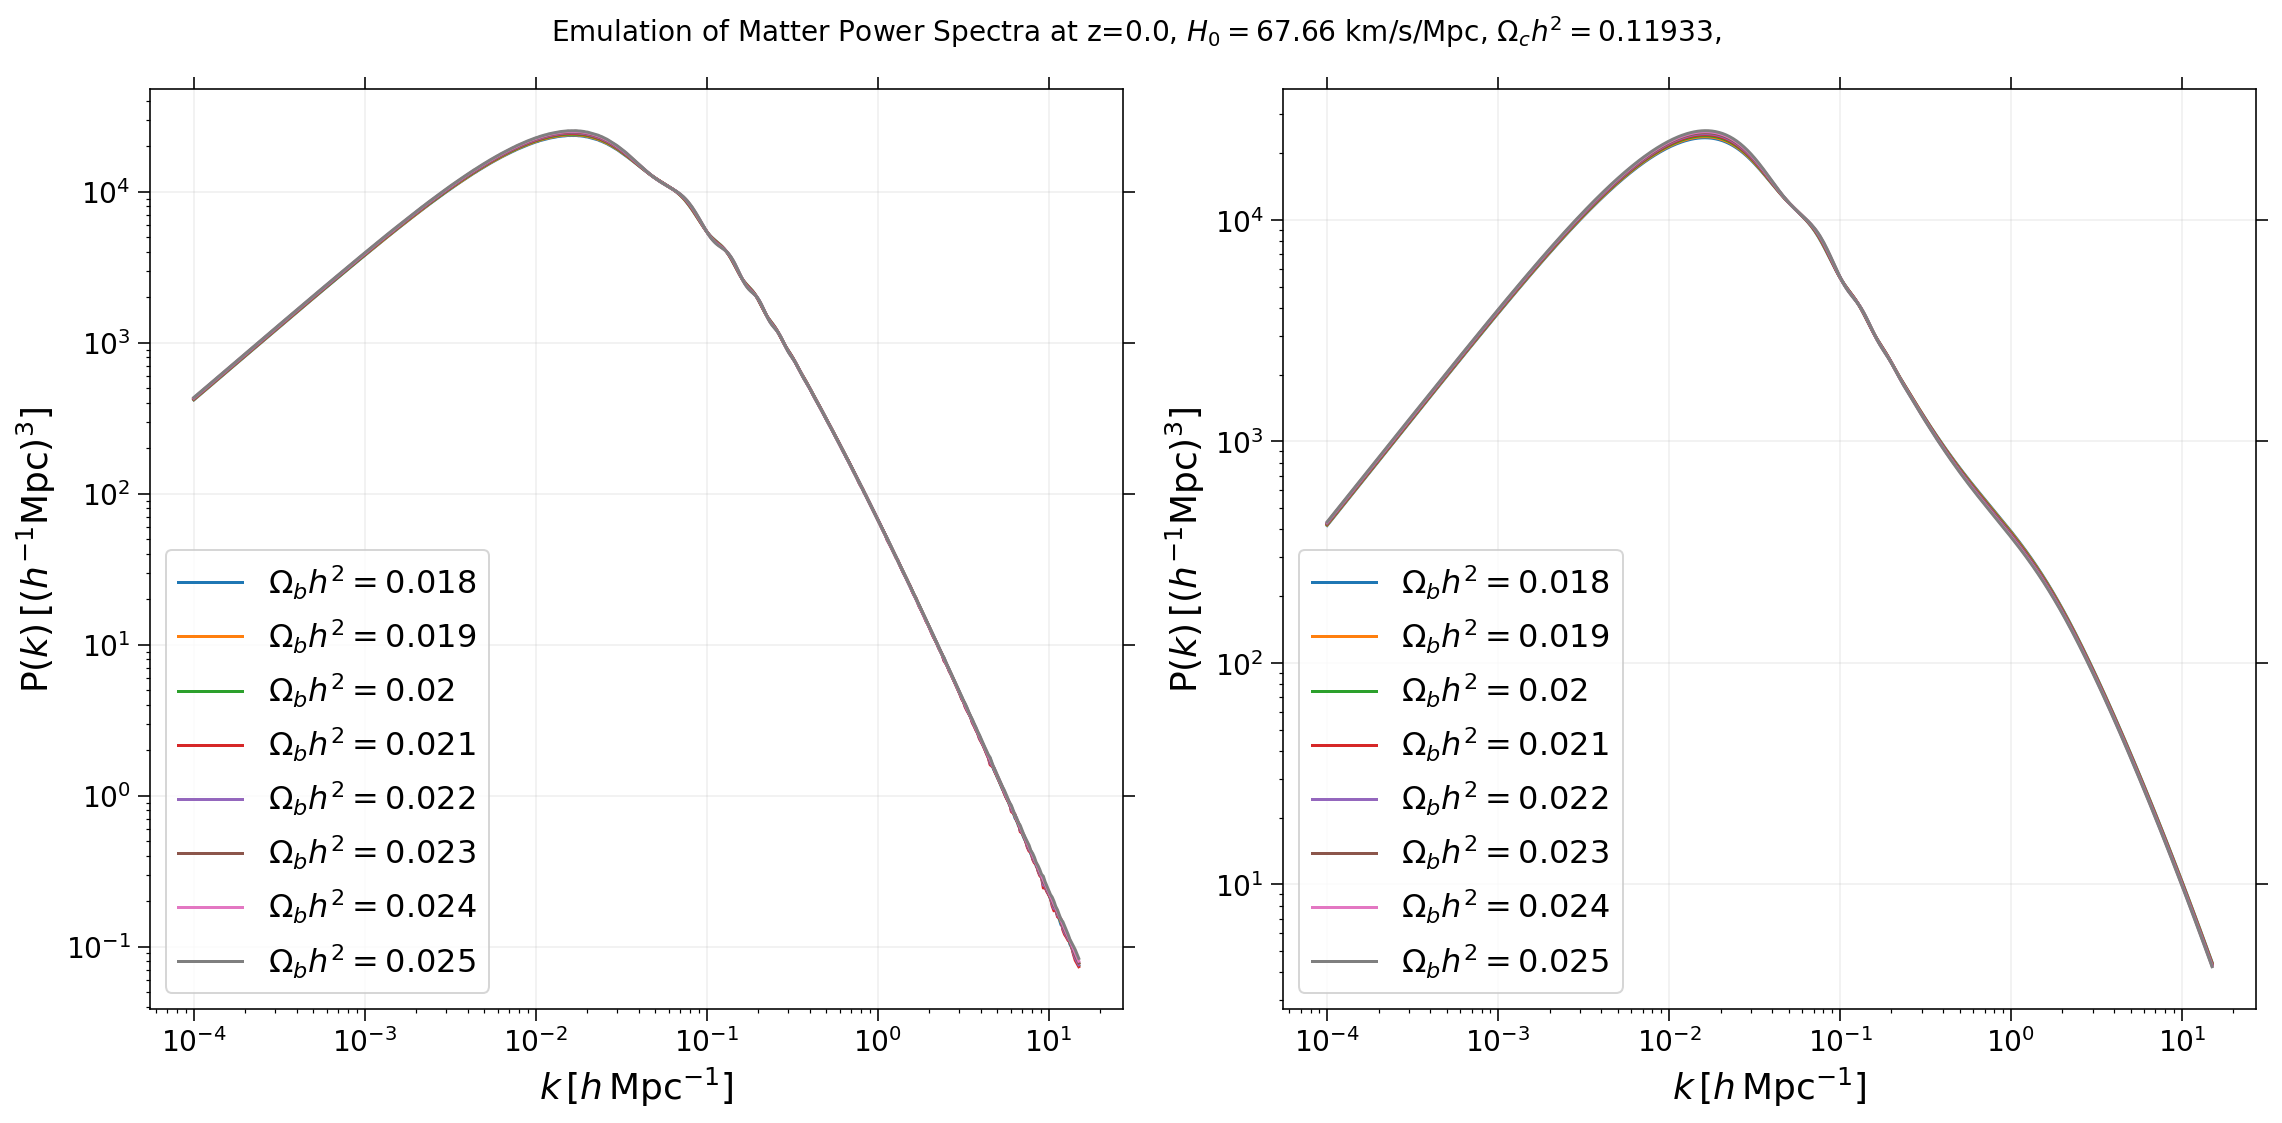

In [31]:
#Define func:

def calc_cosmo():
    fig, ax = plt.subplots(1,2, sharex=True, figsize = (16,8)) #, gridspec_kw={'height_ratios': [3, 1]}
    ombh2_input = np.linspace(0.0180, 0.0250, 8)
    for w in ombh2_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
        pred_pk_nonlin = scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled]))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=67.66, ombh2=cosmo_arr[0][0], omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur

        # Non-Linear spectra (Halofit)
        pars.NonLinear = model.NonLinear_both
        results.calc_power_spectra(pars)
        camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
        camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur

        print('Omega_b:' , cosmo_arr[0][0])
                                            
        ax[0].loglog(camb_kh, pred_pk[0])                                                                                   
        ax[1].loglog(camb_kh, pred_pk_nonlin[0])                                                  
    fig.suptitle('Emulation of Matter Power Spectra at z=0.0, ' + '$H_{0} = 67.66\ \mathregular{km/s/Mpc}$, ' + '$\Omega_{c}h^{2} = 0.11933$, ', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[0].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(["$\Omega_{b}h^{2} = %0.6s$"%w for w in  ombh2_input], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[0].tick_params(top=True,right=True, length=6)
    
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[1].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[1].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[1].legend(["$\Omega_{b}h^{2} = %0.6s$"%w for w in  ombh2_input], loc='lower left', fontsize=16);
    ax[1].tick_params(top=True,right=True, length=6)

    fig.tight_layout()
    #plt.savefig('NN_MPS_H0_range.jpg')
    plt.show()
    

Generate = calc_cosmo()



parameter:  0.018
user_list: 0.018
cosmo_arr [[0.018]]
cosmo_arr[0] [0.018]
input_scaled [[-1.71481604]]
H0: 0.018


parameter:  0.019
user_list: 0.019
cosmo_arr [[0.019]]
cosmo_arr[0] [0.019]
input_scaled [[-1.2248686]]
H0: 0.019


parameter:  0.02
user_list: 0.02
cosmo_arr [[0.02]]
cosmo_arr[0] [0.02]
input_scaled [[-0.73492116]]
H0: 0.02


parameter:  0.021
user_list: 0.021
cosmo_arr [[0.021]]
cosmo_arr[0] [0.021]
input_scaled [[-0.24497372]]
H0: 0.021


parameter:  0.022
user_list: 0.022
cosmo_arr [[0.022]]
cosmo_arr[0] [0.022]
input_scaled [[0.24497372]]
H0: 0.022


parameter:  0.023
user_list: 0.023
cosmo_arr [[0.023]]
cosmo_arr[0] [0.023]
input_scaled [[0.73492116]]
H0: 0.023


parameter:  0.024
user_list: 0.024
cosmo_arr [[0.024]]
cosmo_arr[0] [0.024]
input_scaled [[1.2248686]]
H0: 0.024


parameter:  0.025
user_list: 0.025
cosmo_arr [[0.025]]
cosmo_arr[0] [0.025]
input_scaled [[1.71481604]]
H0: 0.025


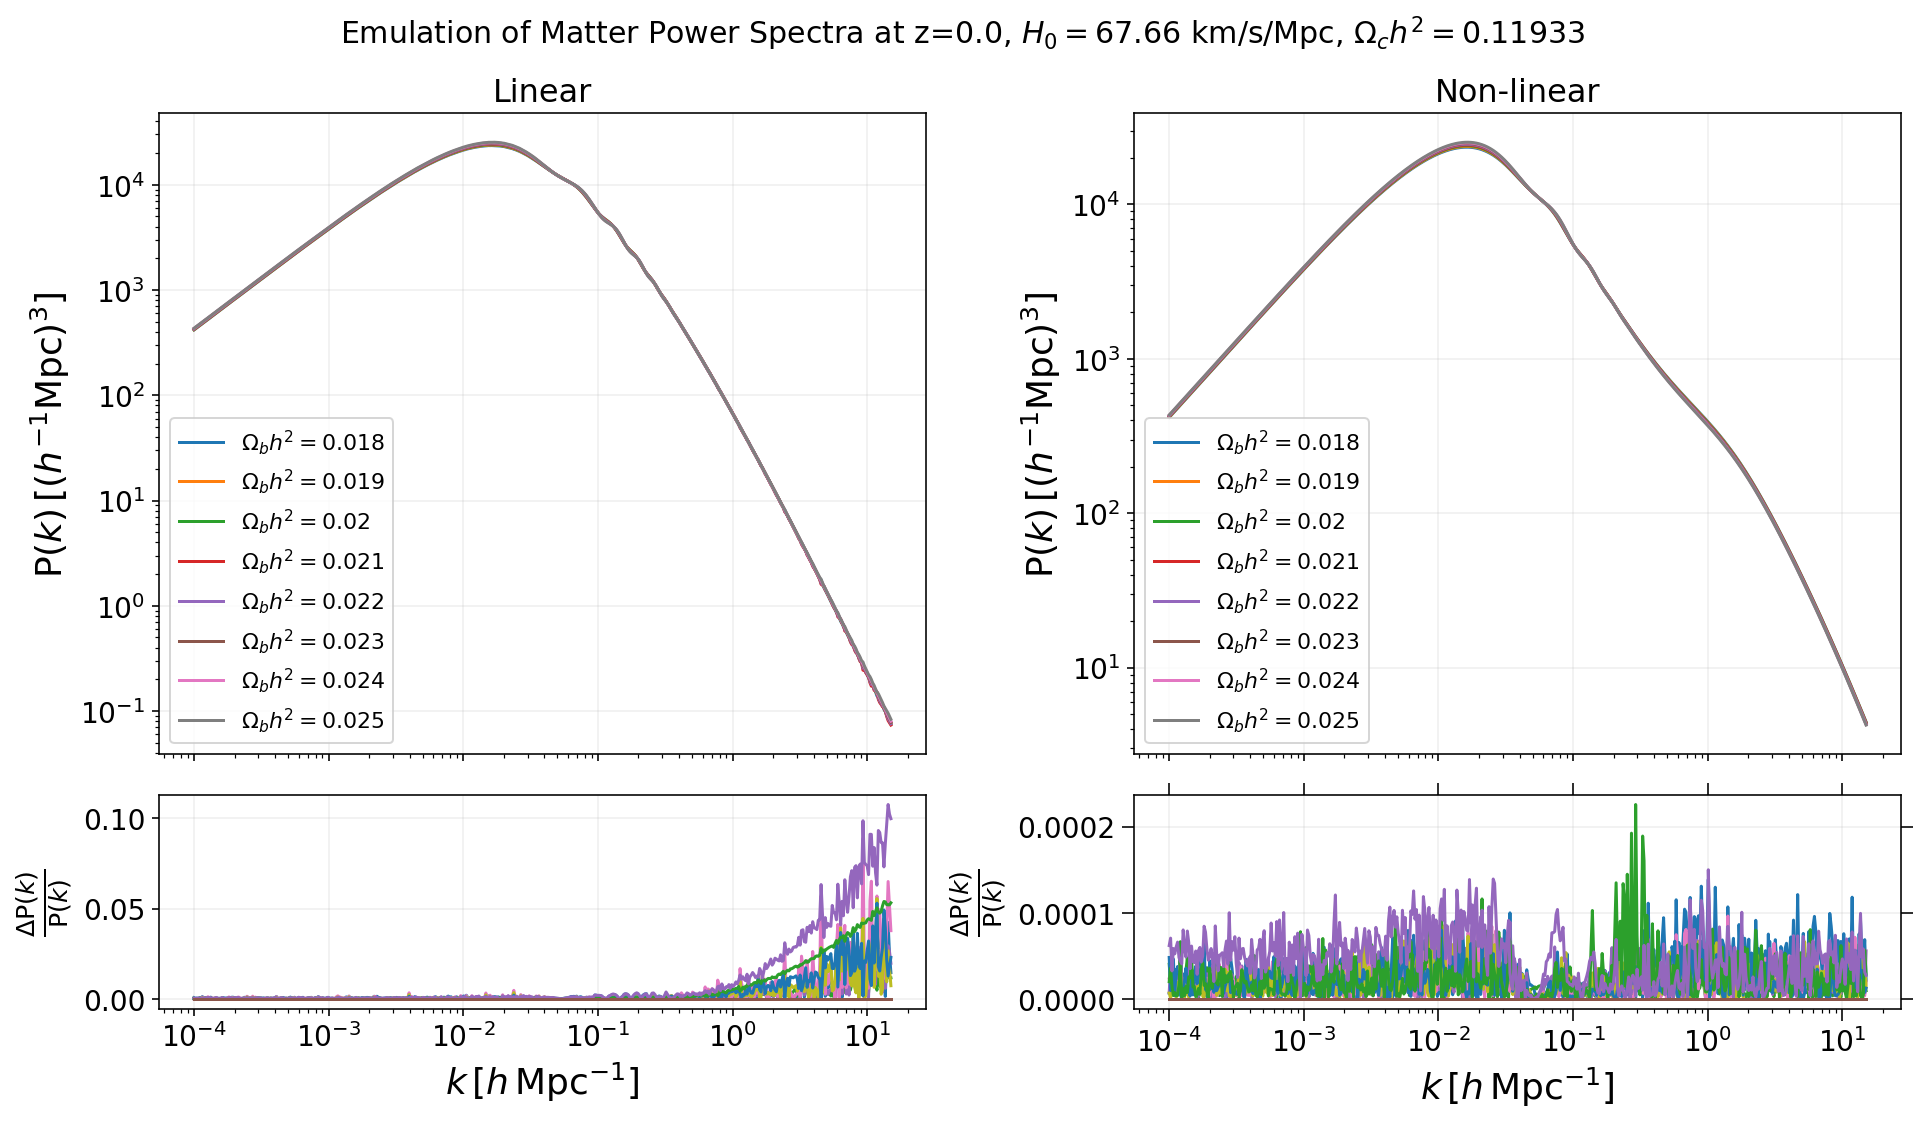

In [30]:
# Define func:

def calc_cosmo():
    
    fig, ax = plt.subplots(2,2, sharex=True, figsize = (13.5,8), gridspec_kw={'height_ratios': [3, 1]})
    ombh2_input = np.linspace(0.0180, 0.0250, 8)
    for w in ombh2_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
        pred_pk_nonlin = scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled]))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=67.66, ombh2=cosmo_arr[0][0], omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur
        
        
        # Non-Linear spectra (Halofit)
        pars.NonLinear = model.NonLinear_both
        results.calc_power_spectra(pars)
        camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
        camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur


        print('H0:' , cosmo_arr[0][0])
        
                                             
        ax[0,0].loglog(camb_kh, pred_pk[0])                                                                       
        ax[0,1].loglog(camb_kh, pred_pk_nonlin[0])
        
        #residual plot 
        ax[1,0].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1,0].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0])) 
        ax[1,0].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]))
        ax[1,0].set_yscale('linear')
        
        ax[1,1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1,1].plot(camb_kh, np.abs((pred_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0])) 
        ax[1,1].plot(camb_kh, np.abs((camb_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]))
        ax[1,1].set_yscale('linear')
        #ax[1].set_ylim(0, 0.05)
        
    fig.suptitle('Emulation of Matter Power Spectra at z=0.0, ' + '$H_{0} = 67.66\ \mathregular{km/s/Mpc}$, ' + '$\Omega_{c}h^{2} = 0.11933$', fontsize = 15)
    ax[0,0].set_title('Linear')
    ax[0,1].set_title('Non-linear')
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    ax[1,0].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[1,1].set_xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0,0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0,1].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0,0].legend(["$\Omega_{b}h^{2} = %0.6s$"%w for w in  ombh2_input], loc='lower left', fontsize=11);
    ax[0,1].legend(["$\Omega_{b}h^{2} = %0.6s$"%w for w in  ombh2_input], loc='lower left', fontsize=11);
    ax[0,0].grid(alpha=0.2)
    ax[1,0].grid(alpha=0.2)
    ax[0,1].grid(alpha=0.2)
    ax[1,1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)


        
    fig.tight_layout()
    #plt.savefig('NN_MPS_H0_range.jpg')
    plt.show()
    

Generate = calc_cosmo()